<a href="https://colab.research.google.com/github/Tizzy1999/ml2019/blob/master/logistic_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#**Linear Regression Assumptions**
* dependent variable should be categorical
* only meaningful variables/features should be included
* features should be independent of each other, avoiding multicollinearity
* independent variables should be linearly correlated to the target variable
* require large sample sizes

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
train = pd.read_csv('/content/gdrive/My Drive/201911ML/titanic/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
# number of observations for each feature
# as you can see, there're some null values for some columns
train.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [0]:
# info on the dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [0]:
# useful statistics detail from the data frame
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#**Exploratory Data Analysis**


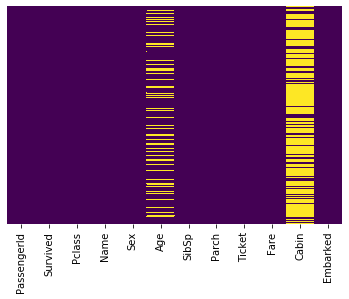

In [0]:
# Missing Data
# use seaborn to crete a simple heatmap to see where we are missing data
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')


* roughly 20% of the ***Age data*** is missing -> replacement with some form of imputation

* ***Cabin column***,  missing too much of that data to do something useful -> we'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

#**Data Visualizations**



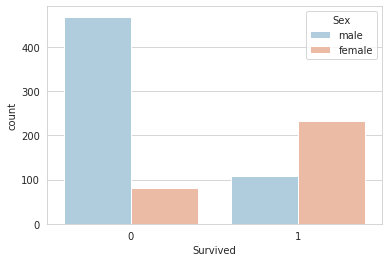

In [0]:
# Survival rate by gender
# count-plot of people survided
sns.set_style('whitegrid')
sns.countplot(x='Survived', hue='Sex', data=train, palette='RdBu_r')


* female seems to be more likely to survive

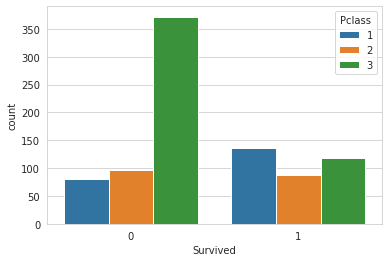

In [0]:
# Survival rate by class
# no. of people who survived according to their Passenger Class
sns.set_style('whitegrid')
sns.countplot(x='Survived', hue='Pclass', data=train)



* people who *did not survive* were more likely to be belonging to third class i.e the lowest class, the cheapest to get on to
* people who *did survive* were more towards belonging to higher classes.

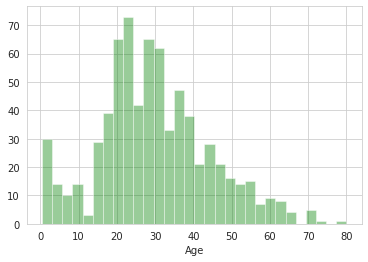

In [0]:
#distribution plot of age of the people
sns.distplot(train['Age'].dropna(), kde=False, bins=30, color='Green')


* The average age group of people to survive is somewhere between 20 to 30and as older you get lesser chances of you to have on board.

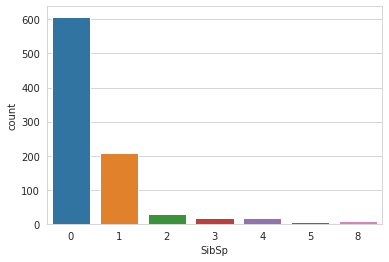

In [0]:
# SiblingSpouse rate
# countplot of the people having siblings or spouce
sns.countplot(x='SibSp',data=train)



* looking at this plot we can directly tell that most people on board did not have either children, siblings or spouse on board
* the second most popular option is 1 which is more likely to be spouse. 
* We have a lot of single people on board, they don’t have spouse or children.

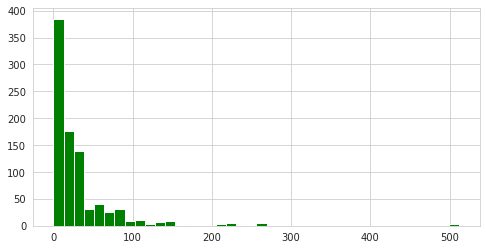

In [0]:
# distribution plot of the ticket fare
train['Fare'].hist(color='green',bins=40,figsize=(8,4))


* It looks like most of the purchase prices are between 0 and50, which actually makes sense tickets are more distributed towards cheaper fare prices because most passengers are in cheaper third class.

#**Data Cleaning**
* fill in missing age data instead of dropping
* one way is by filling the mean age of all passengers

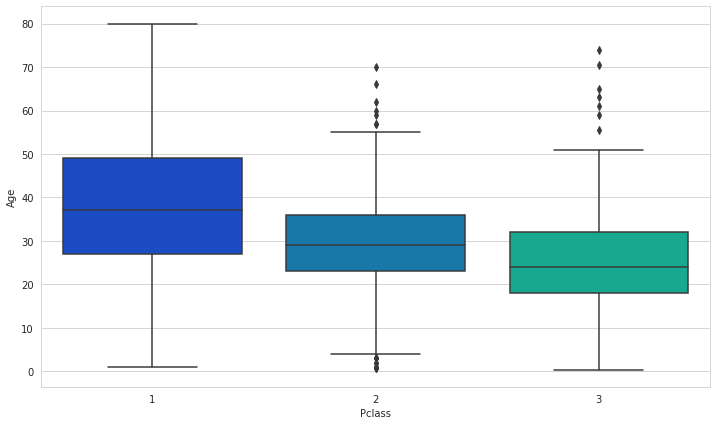

In [0]:
# boxplot with age on y-axis and Passenger class on x-axis.
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass', y='Age', data=train, palette='winter')


* We can see the *wealthier passengers* in the higher classes tend to be older.
* We'll use these average age values to impute based on Pclass for Age.

In [0]:
def impute_age(cols):
  Age = cols[0]
  Pclass = cols[1]
  if pd.isnull(Age):
    if Pclass == 1:
      return 37
    elif Pclass == 2:
      return 29
    else:
      return 24
  else:
    return Age

In [0]:
train['Age'] = train[['Age', 'Pclass']].apply(impute_age, axis=1)

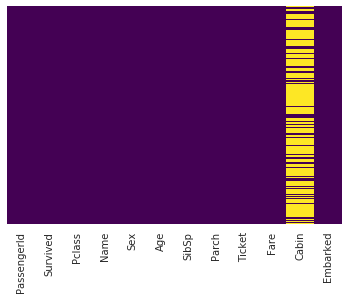

In [0]:
sns.heatmap(train.isnull(), yticklabels=False,cbar=False,cmap='viridis')

* As you can see from the heatmap, there's no longer any null value for the age column.

In [0]:
# drop Cabin column and the row in Embarked that's NaN
train.drop('Cabin', axis=1, inplace=True)
train.dropna(inplace=True)


In [0]:
train.count()

PassengerId    889
Survived       889
Pclass         889
Name           889
Sex            889
Age            889
SibSp          889
Parch          889
Ticket         889
Fare           889
Embarked       889
dtype: int64

In [0]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


#**Converting Categorical Features**

* We'll need to convert *categorical features* to *dummy variables* using pandas
* Otherwise, the machine learning algorithm won't be able to directly take in those features as inputs



In [0]:
sex = pd.get_dummies(train['Sex'], drop_first=True)
embark = pd.get_dummies(train['Embarked'], drop_first=True)

# drop the sex, embarked, name and tickets columns
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

#concatenate new sex and embark column to our train dataframe
train = pd.concat([train,sex,embark],axis=1)
#check the head of dataframe
train.head()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


#**Building a logistic Regression model**


In [0]:
# Train Test Split
from sklearn.model_selection import train_test_split

X = train.drop('Survived', axis=1)
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [0]:
# Training and Predicting

from sklearn.linear_model import LogisticRegression
#create an instance and fit the model 
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Predictions
predictions = logmodel.predict(X_test)

#**Model Evaluation**

In [0]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, predictions)
print(cnf_matrix)

[[151  12]
 [ 36  68]]


Text(0.5, 257.44, 'Predicted label')

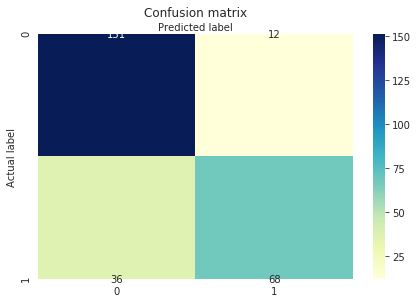

In [0]:
# visualizing confusion matrix using heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [0]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))

Accuracy: 0.8202247191011236
Precision: 0.85
Recall: 0.6538461538461539


* **accuracy**: classification rate of 0.82
* **precision**: when a model makes prediction, how often it's correct. In this case, when our model predicted whether the passengers are going to die, that passenger will 85% of the time.
* **recall**: if there're passengers who died in the test set and our model can identify it 65% of the day. 


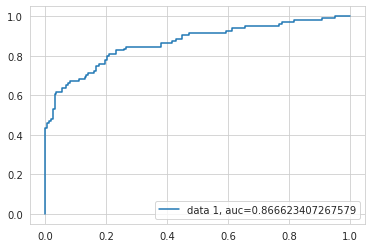

In [0]:
y_pred_proba = logmodel.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

* **ROC Curve**: true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.